In [1]:
%run ../../DataFiles_and_Notebooks/talktools.py

# Making Python Faster

<img src="slides/warp1.jpg">


<h2> ... and using legacy code</h2>

- we've already seen `numexpr`, parallelization, etc.

- Python is _slow_ ... it's interpreted on the fly

- no static typing ... even integers are objects (bulky memory!)

- what if we want to write Python, but use it as a *glue* to fast C-code?

<pre>
Premature optimization is the root of all evil 
   -- Donald Knuth
</pre>

<pre>
C is premature optimization
   -- Josh Bloom
</pre>


## Profiling ##

You already know that Python comes with batteries include, and performance profiling is no exception.

You can keep track of how much time each *function* is taking up using tools from the standard library.

Here's the [documentation of `profile` and `cProfile`](http://docs.python.org/3/library/profile.html), but you probably won't need to use them directly.  A profile is a set of statistics that describes how often and for how long various parts of the program executed. These statistics can be formatted into reports via the pstats module.

In [2]:
import cProfile
import re
cProfile.run('re.compile("fizz|buzz")') # run a piece of code

         236 function calls (229 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 enum.py:358(__call__)
        2    0.000    0.000    0.000    0.000 enum.py:670(__new__)
        1    0.000    0.000    0.000    0.000 enum.py:977(__and__)
        1    0.000    0.000    0.000    0.000 re.py:250(compile)
        1    0.000    0.000    0.000    0.000 re.py:289(_compile)
        1    0.000    0.000    0.000    0.000 sre_compile.py:249(_compile_charset)
        1    0.000    0.000    0.000    0.000 sre_compile.py:276(_optimize_charset)
        2    0.000    0.000    0.000    0.000 sre_compile.py:453(_get_iscased)
        1    0.000    0.000    0.000    0.000 sre_compile.py:461(_get_literal_prefix)
        1    0.000    0.000    0.000    0.000 sre_compile.py:492(_get_charset_prefix)
        1   

In [3]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

# here's the code you want to profile
def waste_of_time(n=1000):
    [x for x in range(n)]
[waste_of_time(y) for y in range(10000)]
## end of code you want to profile

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         20068 function calls in 2.442 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    2.442    0.814 /Users/jbloom/ay250/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3416(run_code)
        3    0.000    0.000    2.442    0.814 {built-in method builtins.exec}
        1    0.000    0.000    2.442    2.442 /var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/ipykernel_11378/2329091808.py:8(<module>)
        1    0.008    0.008    2.442    2.442 /var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/ipykernel_11378/2329091808.py:8(<listcomp>)
    10000    0.372    0.000    2.434    0.000 /var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/ipykernel_11378/2329091808.py:6(waste_of_time)
    10000    2.062    0.000    2.062    0.000 /var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/ipykernel_11378/2329091808.py:7(<listcomp>)
        3    0.000    0.000    0.000    0.000 /Users/jbloom/ay250/lib/p

## There's a magic for that!

### `%timeit` to learn how long it takes a chunk of code to run

### `%prun` for function-by-function breakdown of code in your namespace

### `%run -p` for function-by-function breakdown of running a whole file

In [4]:
cd demos/profile

/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile


In [5]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((5000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [6]:
import sometask

In [7]:
%prun sometask.execute()

Squaring some numbers...
 

In [8]:
%run -p sometask.py

Squaring some numbers...
 

With the `-D` flag, you can dump the profile to binary file that external tools can use.


You  can also produce this .profile without Jupyter using:

```bash
    python -m cProfile -o sometask.profile sometask.py
```

In [9]:
%run -p -D sometask.profile sometask.py

Squaring some numbers...
 
*** Profile stats marshalled to file 'sometask.profile'. 


In [10]:
!head sometask.profile

�)�~�    �#<method 'append' of 'list' objects>)�	   r   gYx��,�>gYx��,�>{��./Users/jbloom/ay250/lib/python3.9/posixpath.pyiN  normpath)r   r   gYx��,�>gYx��,�>0)r   r   �#<method 'insert' of 'list' objects>)�   r	   g��
�m�>g��
�m�>{)�O/Users/jbloom/ay250/lib/python3.9/site-packages/IPython/utils/syspathcontext.py�0   �	__enter__)r	   r	   g��
�m�>g��
�m�>0)r   r   �#<method 'remove' of 'list' objects>)r	   r	   g!��o�>g!��o�>{)r
q��>�r   ��   �r	   r	   g!��o�>g!��o�>0)r   r   �!<method 'split' of 'str' objects>)r	   r	   g0G9�"�>g0G9�"�>{r   )r	   r	   g0G9�"�>g0G9�"�>0)r   r   � <method 'join' of 'str' objects>)r	   r	   g� ���>g� ���>{r   )r	   r	   g� ���>g� ���>0)r   r   �!<method 'rfind' of 'str' objects>)r	   r	   g~�<8�>g~�<8�>{�r   �   �dirname)r	   r	   g~�<8�>g~�<8�>0)r   r   �"<method 'rstrip' of 'str' objects>)r	   r	   g�ۮ#P��>g�ۮ#P��>{r   )r	   r	   g�ۮ#P��>g�ۮ#P��>0)r   r   �&<method '

In [11]:
!pip install snakeviz py-heat-magic

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for py-heat-magic: filename=py_heat_magic-0.0.2-py3-none-any.whl size=3160 sha256=b168022bb59b8bd5aa6c08a211cc9befe8b3875caa63f186903f627b0f4384ca
  Stored in directory: /Users/jbloom/Library/Caches/pip/wheels/f6/0b/58/4c95098dfdd6870497f918d63519673b6006357c4356545192
  Created wheel for py-heat: filename=py_heat-0.0.6-py2.py3-none-any.whl size=7811 sha256=b7034335f6d09e98e86a2d124530822a75fb49d2903b613de30d41f743045581
  Stored in directory: /Users/jbloom/Library/Caches/pip/wheels/29/91/d9/626429dece427775d4662ac1408c774d8a8ab62afbeb845230
  Created wheel for pprofile: filename=pprofile-2.1.0-py3-none-any.whl size=36290 sha256=c066cc6ed54f2ca24ae5d3364443e03c6b0cb7cff776084f2293e759fc7dafa1
  Stored in directory: /Users/jbloom/Library/Caches/pip/wheels/fc/42/97/c5dfca0

In [12]:
!snakeviz sometask.profile

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fjbloom%2FClasses%2Fpython-seminar%2FLectures%2F11_Cython%2Fdemos%2Fprofile%2Fsometask.profile
^C

Bye!


In [13]:
%load_ext snakeviz

In [14]:
%%snakeviz
sometask.execute()

Squaring some numbers...
 
*** Profile stats marshalled to file '/var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/tmpt72rvoqj'. 
Embedding SnakeViz in this document...


## Profiling line-by-line

    %lprun
    
This magic is not built into Jupyter, it is provided by the [line_profiler package by Robert Kern](http://pythonhosted.org/line_profiler/).

In [16]:
#!conda install line_profiler -y

In [17]:
%load_ext line_profiler

Run the code, but only run the line profiler on the function `square()`

In [18]:
import sometask

In [19]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((5000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [20]:
%lprun -f sometask.square sometask.execute()

Squaring some numbers...


In [21]:
%load_ext heat 

In [23]:
import numpy as np

Squaring some numbers...


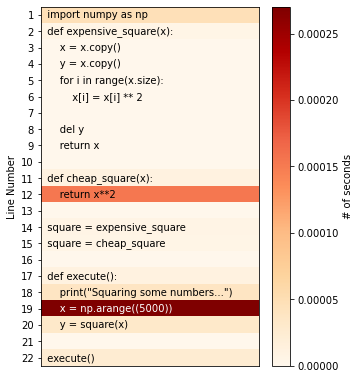

In [27]:
%%heat 
import numpy as np
def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((5000))
    y = square(x)
    
execute()

## Profiling memory usage (line-by-line)

    %mprun
    
        
This magic is not built into Jupyter, it is provided by the [memory_profiler package by Fabian Pedregosa](https://pypi.python.org/pypi/memory_profiler).

In [28]:
!pip install  -U memory_profiler

In [29]:
%load_ext memory_profiler

In [30]:
%mprun?

In [31]:
cd demos/profile

[Errno 2] No such file or directory: 'demos/profile'
/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile


In [32]:
import sometask

In [33]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((5000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [34]:
%mprun -f sometask.square sometask.execute()

Squaring some numbers...



# Other tools for profiling:

[gprof](http://en.wikipedia.org/wiki/Gprof) -- command line profiling tool for C code. [GNU Gprof documentation](https://sourceware.org/binutils/docs/gprof/) is pretty good.

[valgrind](http://valgrind.org/docs/manual/cl-manual.html) -- very complex suite for analyzing callgrind and kcachegrind. "*Valgrind is an instrumentation framework for building dynamic analysis tools. There are Valgrind tools that can automatically detect many memory management and threading bugs, and profile your programs in detail.*"

[memray](https://github.com/bloomberg/memray) track memory allocations in Python code, in native extension modules, and in the Python interpreter itself. It can generate several different types of reports to help you analyze the captured memory usage data. Works on linux.

[Timing and Profiling in IPython](http://pynash.org/2013/03/06/timing-and-profiling/) : Blogpost at the PyNash

Calculate the variance

$$\sigma^2 = \frac {\sum_{i=1}^N (x_i - \sum_{j=1}^N x_j/N)^2}{N - 1}. $$

problem here is that you must first pass over all the data (to get the mean) then pass over the data again.  There's a bunch of Pythonic ways to do this. Here's a few...

In [10]:
#%%writefile var.py
def variance(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean += float(x)
    
    sample_mean /= len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (float(x) - sample_mean) ** 2
    
    return sum_of_squared_errors / (float(len(data)) - 1.0)
    
def variance0(data):
    sample_mean = sum(data) / len(data) # loop 1
    sum_of_squared_errors = sum((i - sample_mean) ** 2 for i in data) # loop 2
    return sum_of_squared_errors / (len(data) - 1)

import functools
def variance1(data):
    mean = float(functools.reduce(lambda x,y : x+y, data)) / len(data)
    return functools.reduce(lambda x,y: x+y, map(lambda xi: (xi-mean)**2, data))/ (len(data) - 1)

def execute():
    variance(range(100000))
    
def execute1():
    variance1(range(100000))

In [3]:
%timeit variance(range(100000))

41.5 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%timeit variance0(range(100000))

22.3 ms ± 604 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%timeit variance1(range(100000))

43.6 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We'd like to do this with just one pass over the data. Have a look at Welford's Method (1962):

In [6]:
def online_variance(data):
    mean,M2= 0.,0.
    for n,d in enumerate(data):
        delta = d - mean
        mean += delta/(n + 1)
        M2 += delta*(d - mean)  
    return M2/n

In [7]:
%timeit online_variance(range(100000))

31.2 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
import var
import importlib
importlib.reload(var)

<module 'var' from '/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/var.py'>

In [12]:
%load_ext line_profiler

In [13]:
%lprun -f var.variance var.execute()